## Sentiment analysis using LSTM network or GRU.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping



In [2]:
df = pd.read_csv(r'C:\Users\shubh\Downloads\Classroom\TY\Sem V\Deep Learning\Lab\Assignmet 6\Tweets.csv')
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [5]:
print(df['airline_sentiment'].value_counts())

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [6]:
# ✅ Text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'[^a-z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['clean_text'] = df['text'].apply(clean_text)

# ✅ Encode target labels
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['airline_sentiment'].map(sentiment_map)

print(df[['text', 'clean_text', 'airline_sentiment', 'label']].head())


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text airline_sentiment  label  
0                   virginamerica what dhepburn said           neutral      1  
1  virginamerica plus youve added commercials to ...          positive      2  
2  virginamerica i didnt today must mean i need t...           neutral      1  
3  virginamerica its really aggressive to blast o...          negative      0  
4  virginamerica and its a really big bad thing a...          negative      0  


In [7]:
# ✅ Tokenization
MAX_VOCAB = 10000
MAX_LEN = 100
EMBED_DIM = 128

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

X = padded
y = df['label'].values

# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape)
print("Testing samples:", X_test.shape)


Training samples: (11712, 100)
Testing samples: (2928, 100)


In [9]:
# ✅ LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_shape=(MAX_LEN,)),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


lstm_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

lstm_model.summary()


c:\Users\shubh\Downloads\AI ML\venv\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,559,811 (5.95 MB)

 Trainable params: 1,559,811 (5.95 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 344ms/step - accuracy: 0.6275 - loss: 0.8854 - val_accuracy: 0.7288 - val_loss: 0.6097
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 364ms/step - accuracy: 0.7756 - loss: 0.5568 - val_accuracy: 0.8043 - val_loss: 0.5091
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 327ms/step - accuracy: 0.8573 - loss: 0.3920 - val_accuracy: 0.8036 - val_loss: 0.5012
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 30s 321ms/step - accuracy: 0.8866 - loss: 0.3227 - val_accuracy: 0.7999 - val_loss: 0.5304
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 304ms/step - accuracy: 0.9113 - loss: 0.2594 - val_accuracy: 0.7923 - val_loss: 0.5575
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.9283 - loss: 0.2185 - val_accuracy: 0.7893 - val_loss: 0.6400


In [12]:
# ✅ GRU Model
gru_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=EMBED_DIM, input_shape=(MAX_LEN,)),
    Bidirectional(GRU(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


gru_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

gru_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,494,787 (5.70 MB)

 Trainable params: 1,494,787 (5.70 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.6235 - loss: 0.8888 - val_accuracy: 0.7490 - val_loss: 0.5934
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.7861 - loss: 0.5439 - val_accuracy: 0.7927 - val_loss: 0.5185
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - accuracy: 0.8365 - loss: 0.4310 - val_accuracy: 0.8050 - val_loss: 0.5017
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.8763 - loss: 0.3472 - val_accuracy: 0.7958 - val_loss: 0.5279
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 334ms/step - accuracy: 0.8998 - loss: 0.2840 - val_accuracy: 0.7988 - val_loss: 0.5892
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 360ms/step - accuracy: 0.9173 - loss: 0.2348 - val_accuracy: 0.7910 - val_loss: 0.6556


In [14]:
# ✅ Evaluate LSTM
y_pred_lstm = np.argmax(lstm_model.predict(X_test), axis=1)
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Neutral', 'Positive']))
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))

# ✅ Evaluate GRU
y_pred_gru = np.argmax(gru_model.predict(X_test), axis=1)
print("GRU Classification Report:\n", classification_report(y_test, y_pred_gru, target_names=['Negative', 'Neutral', 'Positive']))
print("GRU Accuracy:", accuracy_score(y_test, y_pred_gru))


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      1835
     Neutral       0.64      0.63      0.63       620
    Positive       0.77      0.65      0.71       473

    accuracy                           0.80      2928
   macro avg       0.76      0.73      0.74      2928
weighted avg       0.80      0.80      0.80      2928

LSTM Accuracy: 0.8036202185792349
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
GRU Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.91      0.88      1835
     Neutral       0.66      0.61      0.63       620
    Positive       0.78      0.67      0.72       473

    accuracy                           0.80      2928
   macro avg       0.76      0.73      0.74      2928
weighted avg       0.80      0.80      0.80      2928

GRU Accuracy: 0.8049863387978142


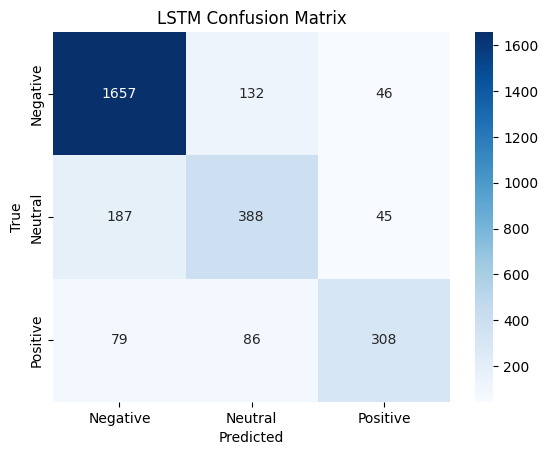

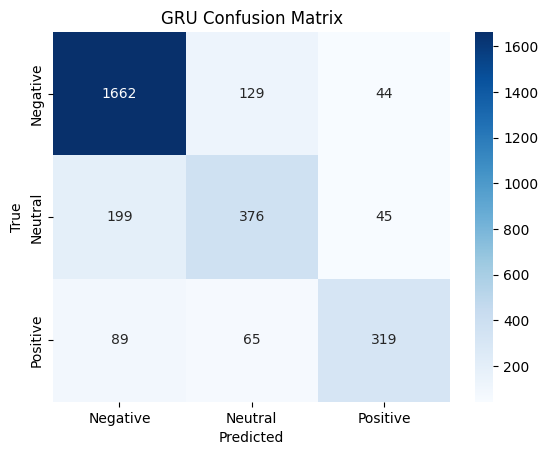

In [15]:
# ✅ Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_test, y_pred_lstm, "LSTM Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_gru, "GRU Confusion Matrix")


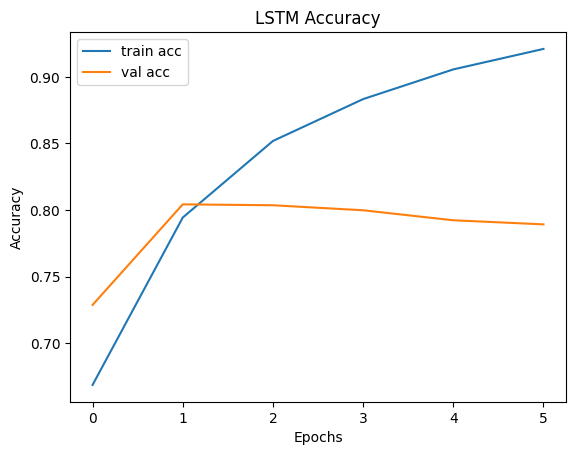

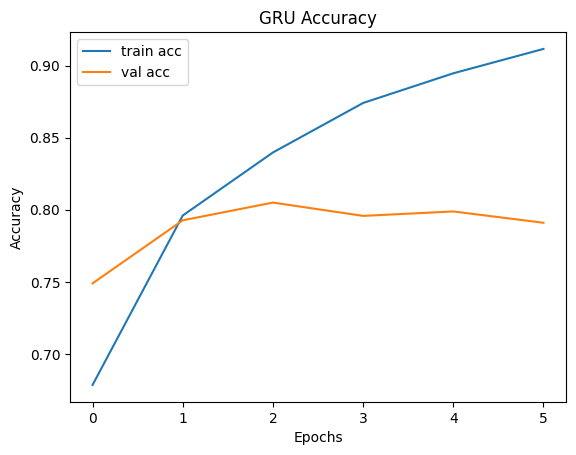

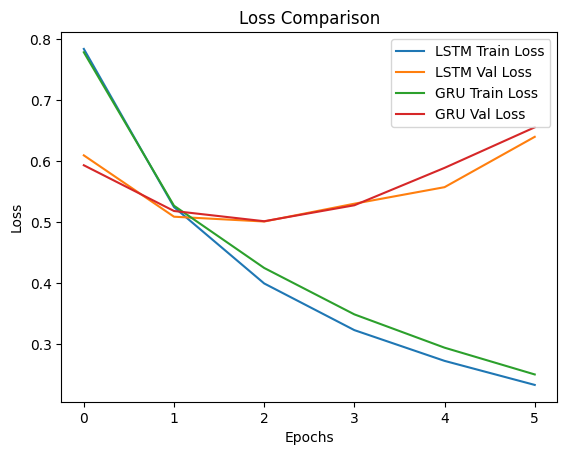

In [16]:
# ✅ Compare Training Curves
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_lstm, "LSTM Accuracy")
plot_history(history_gru, "GRU Accuracy")

plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Val Loss')
plt.title("Loss Comparison")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
